# Post-WTMM generation of terminus position timeseries along flowlines

By Jukes Liu (jukesliu@boisestate.edu)

_Last modified 2021-07-29._


This script is run after the WTMM analysis is complete in order to extract terminus positions from the automated delinations. Relative terminus positions are calculated along three glacier flowlines, created automatically using the glacier terminus box.

The code is streamlined to analyze images for hundreds of glaciers, specifically, the marine-terminating glaciers along the periphery of Greenland. For use on other glaciers, sections of code must be modified:

##########################################################################################

__Indicates code that must be modified__

##########################################################################################

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import subprocess
import fiona
from shapely.geometry import Polygon, Point
import shapely
import cv2

######################################################################################
basepath = '/home/jukes/Documents/Sample_glaciers/' # path to directory containing folders with terminus boxes
os.chdir('/Users/jukesliu/Documents/AUTO-TERMINUS/automated-glacier-terminus')
######################################################################################

# import necessary functions from automated-glacier-terminus.py
from automated_terminus_functions import midpoint, results_allglaciers

# 1) Grab the BoxIDs for the glaciers

In [3]:
# Use one of the csv files to grab the glacier BoxIDs
######################################################################################
VEL_FILENAME = 'Glacier_vel_manual_SE_3.csv' # name of velocity file generated in preprocess.ipynb Step 7
######################################################################################
velocities_df = pd.read_csv(basepath+VEL_FILENAME, sep=',', dtype=str)
velocities_df = velocities_df.set_index('BoxID')
BoxIDs = list(velocities_df.index)
print(BoxIDs)

['070', '076', '088', '094', '106', '124', '136', '142', '148', '154', '166', '172', '178', '184', '190', '202', '220', '232', '238', '244', '250', '268', '274', '286', '292', '304', '310', '316', '328', '334', '340']


# 2) Automatically generate glacier flowlines from terminus boxes

The vertices of the glacier terminus box (in pixel coordinates) will be used to calculate a 3 points (1/4, 1/2, 3/4 across the box width)  on the left edge of the terminus box, which will be our reference point for calculating terminus position. There are 2 methods to finding the correct corners and can be treated as 2 passes. If one fails, try the next. If both fail, find and enter the values manually.

In [5]:
# one of the vertex-finding algorithms requires the minimum dimension of the box (width or length)
# which was generated in preprocess.ipynb Step 5
######################################################################################
BOX_FILENAME = 'Buffdist_SE_3.csv' # file generated from preprocess.ipynb Step 5
######################################################################################
dim_df = pd.read_csv(basepath+BOX_FILENAME, sep=',', dtype=str) 
dim_df = dim_df.set_index('BoxID')
dim_df

,Unnamed: 0,Buff_dist_m,min_dim_px
BoxID,,,
070,0,1623,45
076,1,870,37
082,2,1671,67
088,3,618,18
094,4,942,16
100,5,2218,74
106,6,727,31
112,7,783,44
118,8,939,34


## Method 2.1) Use cv2 corner-finding algorithms

070


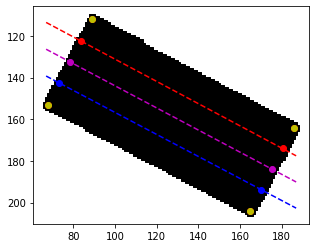

076


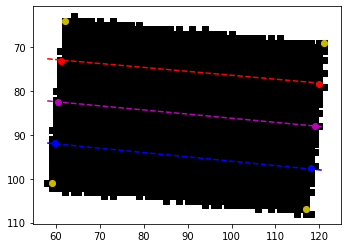

088


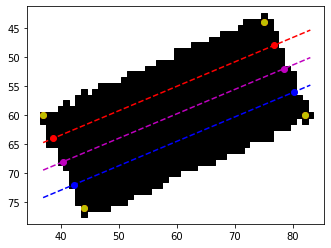

094


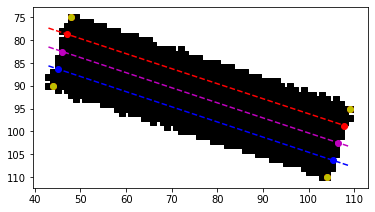

106


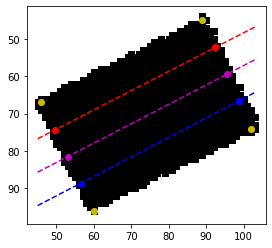

124


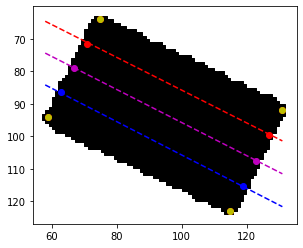

136


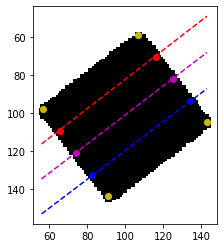

142


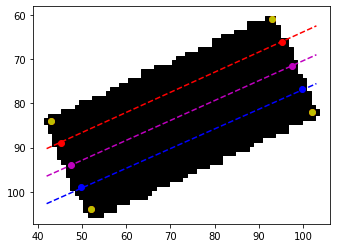

148


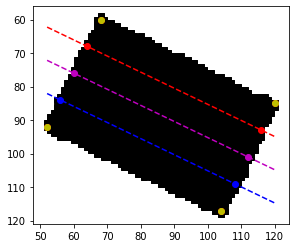

154


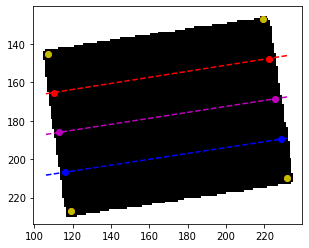

166


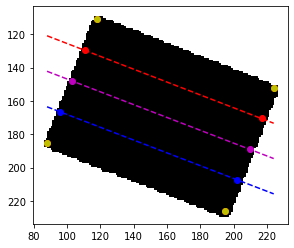

172


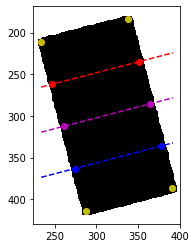

178


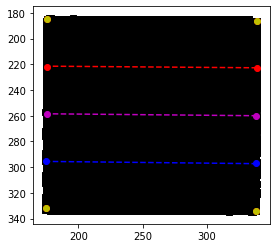

184


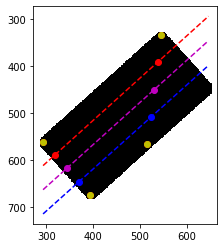

190


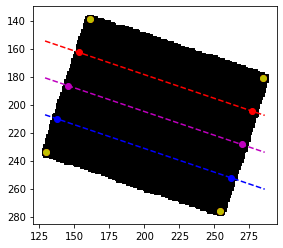

202


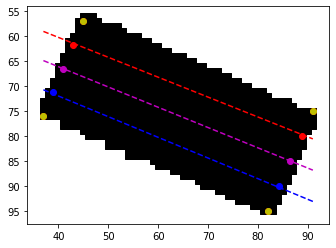

220


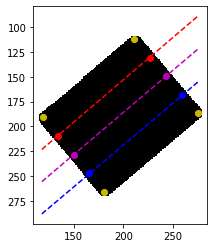

232


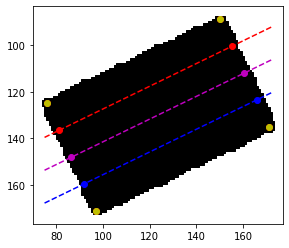

238


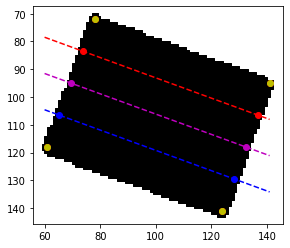

244


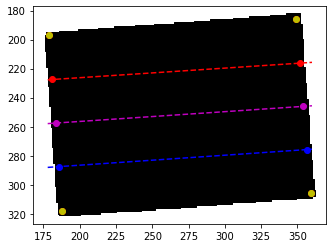

250


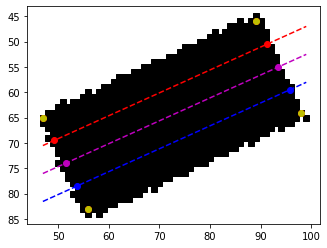

268


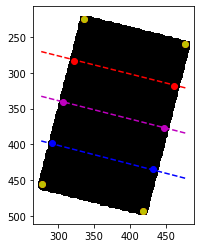

274


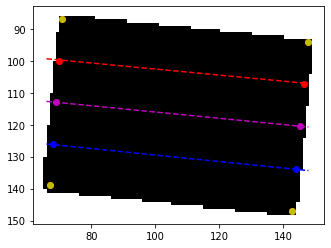

286


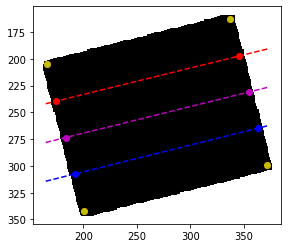

292


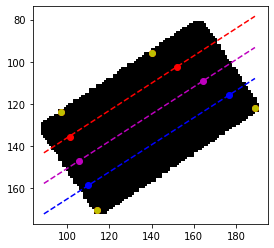

304


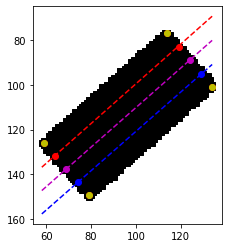

310


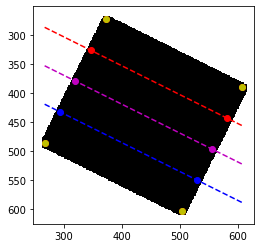

316


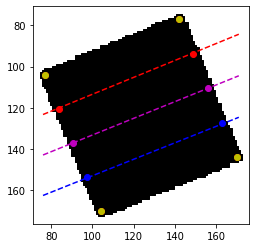

328


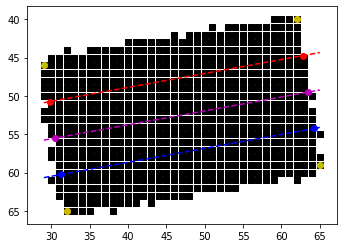

334


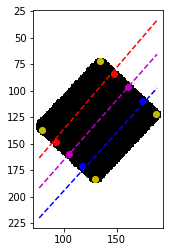

340


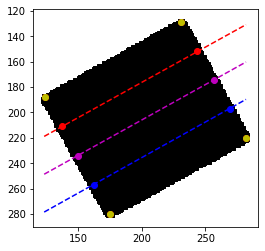

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
070,78.5,132.5,175.5,184.0,0.530928,90.822165,83.75,122.25,180.75,174.00,0.533505,77.784794,73.25,142.75,170.25,194.00,0.528351,103.859536
076,60.5,82.5,119.0,88.0,0.094017,76.811966,61.25,73.25,120.00,78.50,0.089362,67.491453,59.75,91.75,118.00,97.50,0.098712,86.132479
088,40.5,68.0,78.5,52.0,-0.421053,85.052632,38.75,64.00,76.75,48.00,-0.421053,80.315789,42.25,72.00,80.25,56.00,-0.421053,89.789474
094,46.0,82.5,106.5,102.5,0.330579,67.293388,47.00,78.75,107.75,98.75,0.329218,63.212810,45.00,86.25,105.25,106.25,0.331950,71.373967
106,53.0,81.5,95.5,59.5,-0.517647,108.935294,49.50,74.25,92.25,52.25,-0.514620,99.873529,56.50,88.75,98.75,66.75,-0.520710,117.997059
124,67.0,79.0,123.0,107.5,0.508929,44.901786,71.00,71.50,127.00,99.75,0.504464,35.366071,63.00,86.50,119.00,115.25,0.513393,54.437500
136,74.0,121.0,125.0,82.0,-0.764706,177.588235,65.50,109.50,116.00,70.50,-0.772277,159.588235,82.50,132.50,134.00,93.50,-0.757282,195.588235
142,47.5,94.0,97.5,71.5,-0.450000,115.375000,45.25,89.00,95.25,66.25,-0.455000,109.362500,49.75,99.00,99.75,76.75,-0.445000,121.387500
148,60.0,76.0,112.0,101.0,0.480769,47.153846,64.00,68.00,116.00,93.00,0.480769,37.230769,56.00,84.00,108.00,109.00,0.480769,57.076923


In [6]:
# create dictionary to store each terminus box ndarray by BoxID
termboxes2 = {}
  
# Create dictionaries and lists to store coordinates
topleft_coords = {}; bottomleft_coords = {}; topright_coords = {} ;bottomright_coords = {}
#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []; midpoints_y = []; midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []; mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []; mids_r075_x = []; mids_r075_y = []
#create lists to store the slopes and intercepts of the flowline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

# read in the terminus box rasters
for BoxID in BoxIDs:
    ######################################################################################
    # load in the terminus box raster
#     boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated_c1/R_Box"+BoxID+"_raster_cut.png" # modify the path
    ######################################################################################
    
    termbox = cv2.imread(boxpath) # read the raster into an ndarray
    termbox = cv2.cvtColor(termbox, cv2.COLOR_BGR2GRAY) 
       
    boxes_xcoords = {}; boxes_ycoords = {} # dictionary to store the coordinates of the box pixels    
    # from the raster, grab x,y coordinates of pixels correpsonding to the terminus box
    BOI = termbox
    if len(BOI.shape) > 2:
        yindices, xindices, third= np.where(BOI > 0) # keep the pixels of where the box exists
    else:
        yindices, xindices= np.where(BOI > 0) # keep the pixels of where the box exists
    boxes_ycoords.update({BoxID: yindices}); boxes_xcoords.update({BoxID: xindices}) # add to the dictionary
    
    # set 0.95*minimum dimension as the minimum distance between corners
    min_dist = 0.9*int(dim_df.loc[BoxID]['min_dim_px'])
    
    # FIND CORNERS:
    quality = 0.1 # quality threshold for corner tracking
    corners = cv2.goodFeaturesToTrack(termbox,4,quality,min_dist)
    
    cornerxs = []; cornerys = [] # hold corner coordinates
    for i in range(0, 4):
        cornerxs.append(corners[i][0][0]); cornerys.append(corners[i][0][1])
    cornerxs = np.array(cornerxs); cornerys = np.array(cornerys) 
    
    # IDENTIFY THE TWO LEFT COORDINATES:
    # two minimum x values:
    [x1,x2] = np.sort(cornerxs)[:2]
    if x1 == x2:
        print('Two of the same x coordinates, with y:', np.where(cornerxs == x1)[0])
        [x1_i, x2_i] = np.where(cornerxs == x1)[0]
    else:
        x1_i = np.where(cornerxs == x1)[0][0]; x2_i = np.where(cornerxs == x2)[0][0]
    # pair the x and y
    coord1 = [x1, cornerys[x1_i]]; coord2 = [x2,cornerys[x2_i]]
    [ytopleft, ybottomleft] = np.sort([cornerys[x1_i], cornerys[x2_i]])
    for coord in [coord1, coord2]:
        if coord[1] == ytopleft:
            topleft = coord
        elif coord[1] == ybottomleft:
            bottomleft = coord
    
    # IDENTIFY THE TWO RIGHT COORDINATES
    [x3,x4] = np.sort(cornerxs)[2:]
    if x3 == x4:
        print('Two of the same x coordinates, with y:', np.where(cornerxs == x3)[0])
        [x3_i, x4_i] = np.where(cornerxs == x3)[0]
    else:
        x3_i = np.where(cornerxs == x3)[0][0]; x4_i = np.where(cornerxs == x4)[0][0]
    # pair the x and y
    coord3 = [x3, cornerys[x3_i]]; coord4 = [x4,cornerys[x4_i]]
    [ytopright, ybottomright] = np.sort([cornerys[x3_i], cornerys[x4_i]])
    for coord in [coord3, coord4]:
        if coord[1] == ytopright:
            topright = coord
        elif coord[1] == ybottomright:
            bottomright= coord
    
    # add the corner coordinates to the respective dictionaries:
    topleft_coords.update({BoxID: topleft})
    bottomright_coords.update({BoxID: bottomright})
    bottomleft_coords.update({BoxID: bottomleft}) #Add to dictionary of bottomleft coordinates
    topright_coords.update({BoxID: topright})
    
    # CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    # GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y) 
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    # CALCULATE FLOWLINE EQUATIONS (b = y-mx)
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x);b = midpoint_y - (m*midpoint_x)
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x)
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x)
    
    # append BoxIDs, slopes, intercepts, midpoints, and flowlines to lists
    boxes.append(BoxID);
    midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)  
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); 
    mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;
    mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    slope_50.append(m); intercept_50.append(b); 
    slope_25.append(m025); intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
    # PLOT THE RESULTS
    print(BoxID)
    plt.scatter(boxes_xcoords[BoxID], boxes_ycoords[BoxID], c='k',marker='s')
    # plot corners
    for j in range(0, 4):
        corner = corners[j][0]; #print(corner)
        plt.scatter(corner[0], corner[1], c='r') 
    # plot the vertices
    plt.scatter(topleft[0], topleft[1], c='y')
    plt.scatter(bottomleft[0], bottomleft[1], c='y')
    plt.scatter(topright[0], topright[1], c='y')
    plt.scatter(bottomright[0], bottomright[1], c='y')
    # plot midpoints
    plt.scatter(midpoint_x, midpoint_y, c='m'); plt.scatter(midpoint_r_x, midpoint_r_y, c='m')
    plt.scatter(mid_l025_x, mid_l025_y, c='r'); plt.scatter(mid_r025_x, mid_r025_y, c='r')
    plt.scatter(mid_l075_x, mid_l075_y, c='b'); plt.scatter(mid_r075_x, mid_r075_y, c='b')
    # plot the flowlines in cyan
    x=np.linspace(np.min(boxes_xcoords[BoxID]), np.max(boxes_xcoords[BoxID])); 
    y50=m*x + b; y25=m025*x + b025; y75=m075*x + b075
    plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
    plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()
        
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes2.update({BoxID: termbox})
    
# create a dataframe
total_df = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

total_df = total_df.set_index('BoxID')
total_df

## Method 2.2) Try for the boxes where Method 2.1 failed

Visually inspect the results plotted above. If the flowlines for certain glaciers are not generated as well as you'd like, identify those here and try this method.

In [7]:
######################################################################################
# identify trouble boxes:
BoxIDs_trouble = ['184']
######################################################################################

# remove the bad results from total_df
total_df = total_df.drop(BoxIDs_trouble)

In [8]:
boxes_xcoords = {}; boxes_ycoords = {} # dictionary to store the all coordinates of the box rasters
topleft_coords = {}; bottomleft_coords = {} # dictionaries for the box vertices
topright_coords = {}; bottomright_coords = {}
# lists to store the left and right quarter points:
midpoints_x = []; midpoints_y = []; midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []; mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []; mids_r075_x = []; mids_r075_y = []
# lists to store the slopes and intercepts of the flowline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

# for those trouble boxes identified
for BoxID in BoxIDs_trouble:
    BOI = termboxes2[BoxID] # grab the box raster
    if len(BOI.shape) > 2:
        yindices, xindices, third= np.where(BOI > 0) # keep the coordinates of the box pixels
    else:
        yindices, xindices= np.where(BOI > 0) # keep the coordinates of the box pixels
    boxes_ycoords.update({BoxID: yindices}); boxes_xcoords.update({BoxID: xindices}) # add to the dictionary
    
    ######################################################################################
    # THIS IS WHERE YOU CAN MANUALLY ENTER VERTICES IN PIXEL COORDINATES FOR CERTAIN GLACIERS.
    # Glacier 259 is an example. You can add create your own if condition and 
    # add elseifs if there are more to manually enter. If you have no manual entries,
    # uncomment the True == False if statement and comment the rest out, which will just 
    # skip to the code after else.
    
#     if True == False: 
    if BoxID == '259':
        topleft = [117.0, 355.0] # x,y
        bottomleft = [166.0, 426.0]
        topright = [386.0, 169.0]
        bottomright = [435.0, 239.0]
    ######################################################################################
    else:
        # FIND THE TOP LEFT COORDINATES (min x and min y)
        xy = xindices*yindices
        min_xy_i = np.where(xy == np.nanmin(xy))[0][0]  #Find the x and y pair corresponding to that lowest xy
        topleft = [xindices[min_xy_i], yindices[min_xy_i]]

        # FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
        max_xy = np.nanmax(xy)
        max_xy_i = np.where(xy == max_xy)[0][0]
        bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
        
        # FIND THE BOTTOM LEFT COORDINATE(highest y/x)
        y_x = yindices/xindices
        max_y_x = np.nanmax(y_x) #Find the highest y/x value
        #Find the x and y pair corresponding to that y/x using the index
        max_y_x_i = np.where(y_x == max_y_x)[0][0]
        bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
        
        # FIND THE TOP RIGHT COORDINATES (highest x/y)
        x_y = xindices/yindices
        max_x_y = np.nanmax(x_y)  # find highest x/y value
        max_x_y_i = np.where(x_y == max_x_y)[0][0]  #Find the x, y pair correpsonding to the maximum x/y using the index
        topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    
    # add to dictionaries:
    topleft_coords.update({BoxID: topleft})
    bottomright_coords.update({BoxID: bottomright})
    bottomleft_coords.update({BoxID: bottomleft})
    topright_coords.update({BoxID: topright})
    
    # CALCULATE THE MIDPOINTS
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1]) # left
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1]) # right
    
    # GRAB 1/4th AND 3/4ths LINES (another midpoint calculation)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y) 
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    # CALCULATE FLOWLINE EQUATIONS (y_intercept = y1 - m*x1)
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x);b = midpoint_y - (m*midpoint_x) # 1/2 flowline
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x) # 1/4 flowline
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x) # 3/4 flowline
    
    # append BoxIDs, slopes, intercepts, midpoints, and flowlines to lists
    boxes.append(BoxID);
    midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)  
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); 
    mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;
    mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    slope_50.append(m); intercept_50.append(b); 
    slope_25.append(m025); intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
# create a new dataframe
df2 = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

df2 = df2.set_index('BoxID')
df2

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
184,293.0,562.0,551.0,431.5,-0.505814,710.203488,293.0,561.5,548.0,382.75,-0.70098,709.703488,293.0,562.5,554.0,480.25,-0.315134,710.703488


## Now check the new flowline results:

184


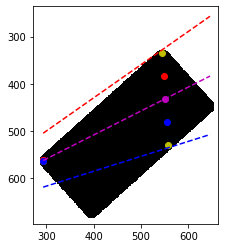

In [12]:
for BOI_ID in BoxIDs_trouble:
#     if BOI_ID == '184': # to select one glacier at a time
        print(BOI_ID)
        # plot the raster pixels in black
        plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')
        # plot the vertices
        plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='y')
        plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='y')
        plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='y')
        plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='y')
        # plot midpoints
        plt.scatter(df2.at[BOI_ID,'lmid50_x'], df2.at[BOI_ID,'lmid50_y'], c='m'); plt.scatter(df2.at[BOI_ID, 'rmid50_x'], df2.at[BOI_ID, 'rmid50_y'], c='m')
        plt.scatter(df2.at[BOI_ID,'lmid25_x'], df2.at[BOI_ID,'lmid25_y'], c='r'); plt.scatter(df2.at[BOI_ID, 'rmid25_x'], df2.at[BOI_ID, 'rmid25_y'], c='r')
        plt.scatter(df2.at[BOI_ID,'lmid75_x'], df2.at[BOI_ID,'lmid75_y'], c='b'); plt.scatter(df2.at[BOI_ID, 'rmid75_x'], df2.at[BOI_ID, 'rmid75_y'], c='b')
        # plot the flowlines in cyan
        x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID])); y50=(df2.at[BOI_ID, 'm50'])*x + (df2.at[BOI_ID, 'b50']); 
        y25=(df2.at[BOI_ID, 'm25'])*x + (df2.at[BOI_ID, 'b25']); y75=(df2.at[BOI_ID, 'm75'])*x + (df2.at[BOI_ID, 'b75'])
        plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
        # plot parameters      
        plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()

## If successful, add these back to the full data table:

In [19]:
total_df = pd.concat([total_df, df2])

## Drop the righthand points (we only need the left) and save to file

In [3]:
total_df = total_df.drop(['rmid50_y', 'rmid25_y', 'rmid75_y'], axis=1)
# total_df # show the resulting dataframe

NameError: name 'total_df' is not defined

In [14]:
######################################################################################
FLINE_FILENAME = 'Boxes_coords_pathrows_SE_3.csv' # change filename as desired
######################################################################################
total_df.to_csv(path_or_buf = basepath+FLINE_FILENAME, sep=',')

# 3) Generate the terminus position time series

(2009, 2)
Box070
(908, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 66 dips
Dropping 61 dips
Dropping 48 dips
Dropping 64 jumps
Dropping 105 jumps
Dropping 63 jumps
142
129
151


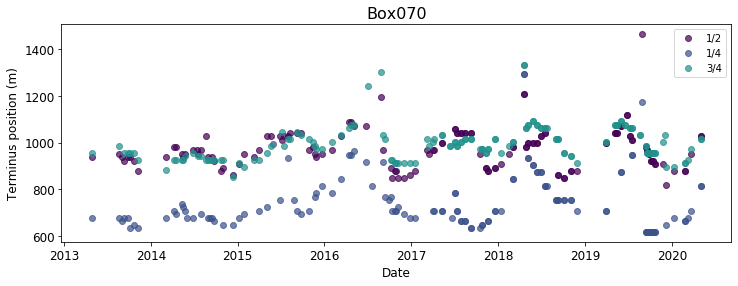

Box076
(902, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 41 dips
Dropping 53 dips
Dropping 84 dips
Dropping 84 jumps
Dropping 70 jumps
Dropping 72 jumps
145
115
139


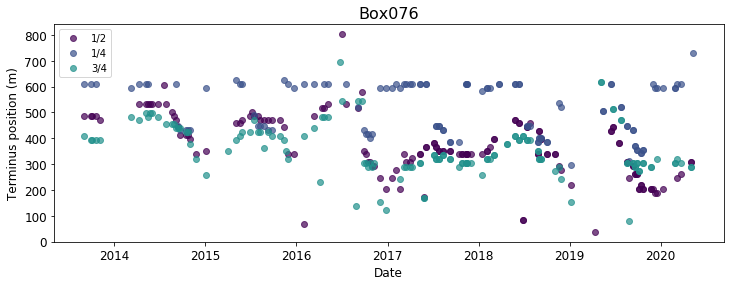

Box088
(925, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 95 dips
Dropping 73 dips
Dropping 135 dips
Dropping 114 jumps
Dropping 98 jumps
Dropping 106 jumps
137
133
130


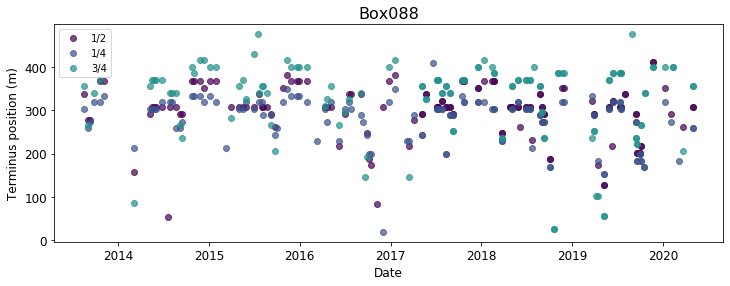

Box094
(1961, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 325 dips
Dropping 274 dips
Dropping 437 dips
Dropping 273 jumps
Dropping 269 jumps
Dropping 322 jumps
281
268
263


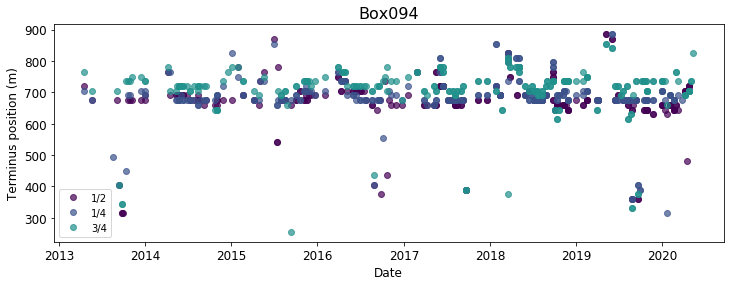

Box106
(1481, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 139 dips
Dropping 109 dips
Dropping 64 dips
Dropping 146 jumps
Dropping 87 jumps
Dropping 167 jumps
206
213
192


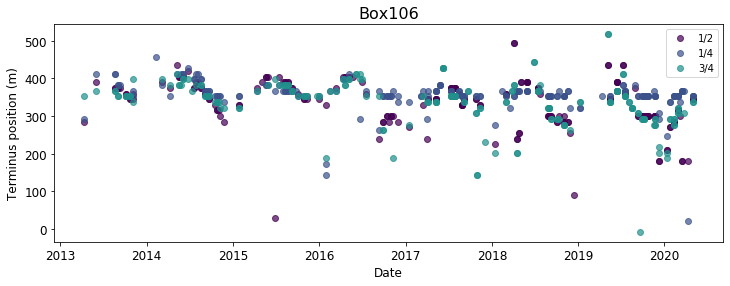

Box124
(795, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 111 dips
Dropping 126 dips
Dropping 123 dips
Dropping 98 jumps
Dropping 99 jumps
Dropping 116 jumps
86
74
95


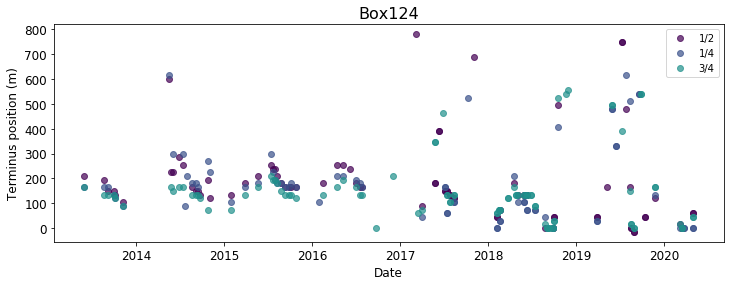

Box136
(1052, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 97 dips
Dropping 79 dips
Dropping 132 dips
Dropping 97 jumps
Dropping 86 jumps
Dropping 52 jumps
153
150
141


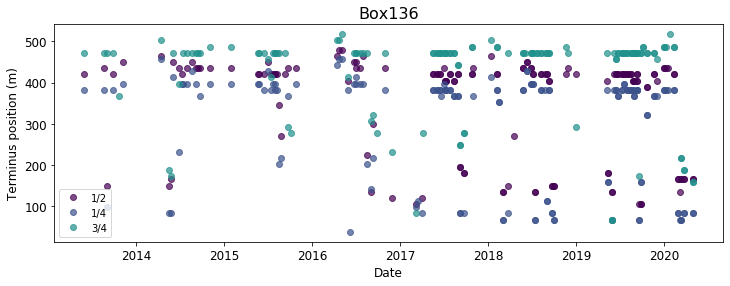

Box142
(815, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 101 dips
Dropping 76 dips
Dropping 82 dips
Dropping 71 jumps
Dropping 66 jumps
Dropping 80 jumps
118
112
123


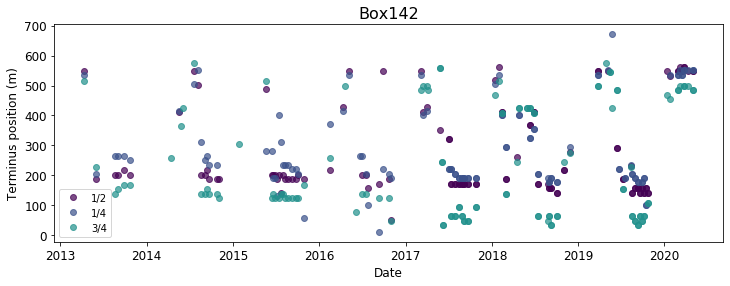

Box148
(810, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 56 dips
Dropping 55 dips
Dropping 54 dips
Dropping 49 jumps
Dropping 76 jumps
Dropping 61 jumps
139
135
123


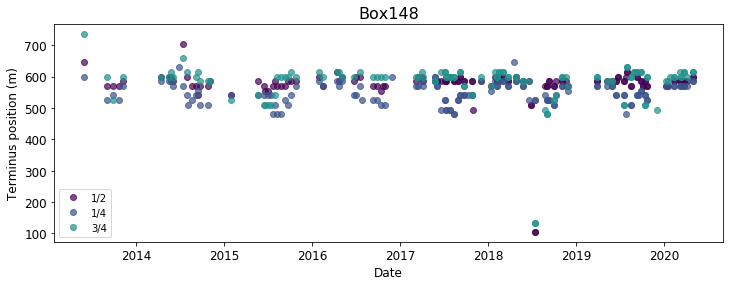

Box154
(843, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 55 dips
Dropping 27 dips
Dropping 146 dips
Dropping 61 jumps
Dropping 39 jumps
Dropping 83 jumps
123
91
122


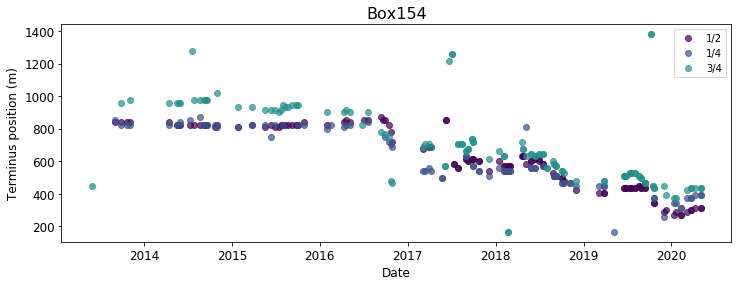

Box166
(766, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 63 dips
Dropping 8 dips
Dropping 74 dips
Dropping 36 jumps
Dropping 37 jumps
Dropping 41 jumps
111
97
120


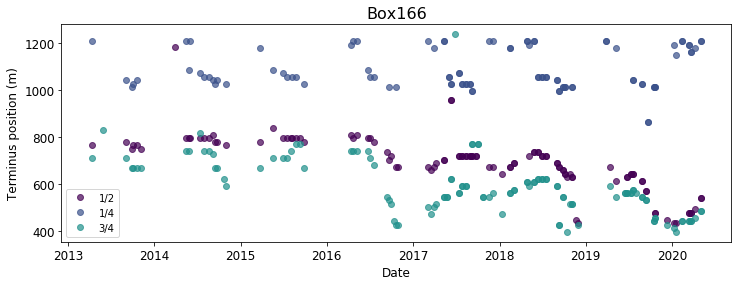

Box172
(831, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 10 dips
Dropping 12 dips
Dropping 36 dips
Dropping 14 jumps
Dropping 33 jumps
Dropping 29 jumps
84
65
99


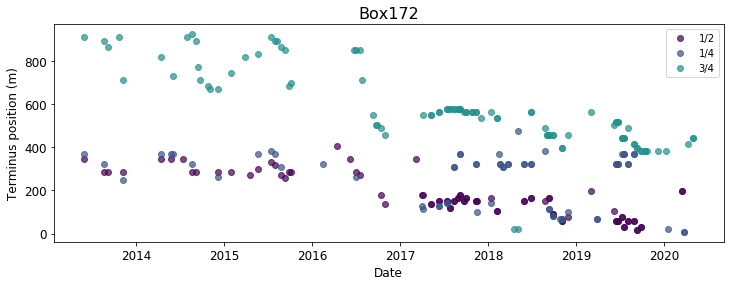

Box178
(775, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 31 dips
Dropping 8 dips
Dropping 31 dips
Dropping 21 jumps
Dropping 10 jumps
Dropping 50 jumps
83
95
119


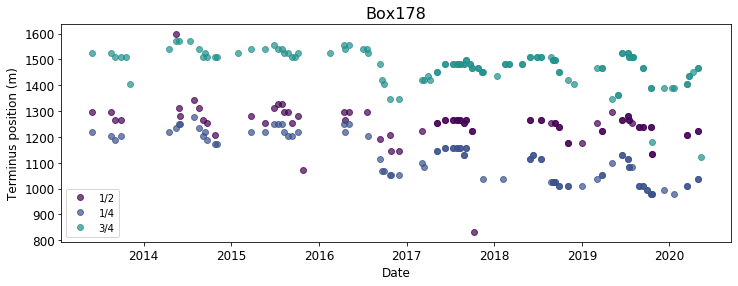

Box190
(1575, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 185 dips
Dropping 111 dips
Dropping 128 dips
Dropping 166 jumps
Dropping 118 jumps
Dropping 257 jumps
178
149
171


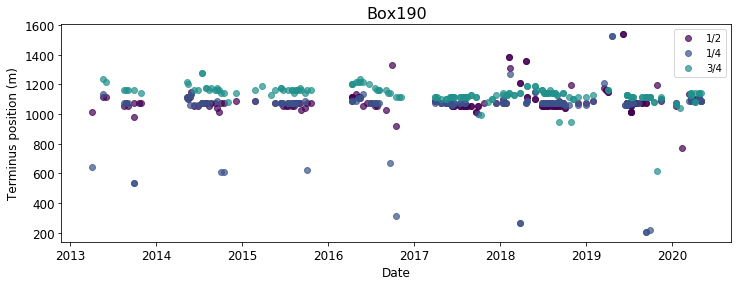

Box202
(941, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 123 dips
Dropping 123 dips
Dropping 98 dips
Dropping 151 jumps
Dropping 76 jumps
Dropping 207 jumps
110
61
138


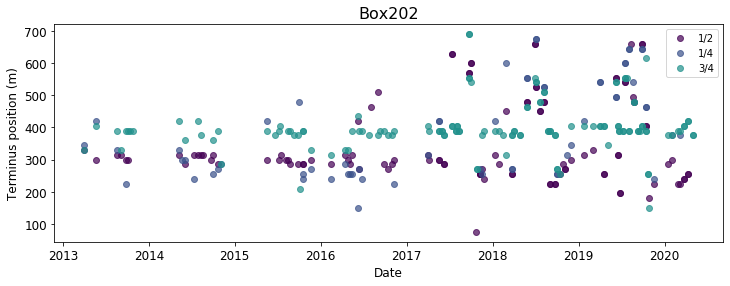

Box220
(1137, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 52 dips
Dropping 52 dips
Dropping 93 dips
Dropping 77 jumps
Dropping 55 jumps
Dropping 43 jumps
151
148
150


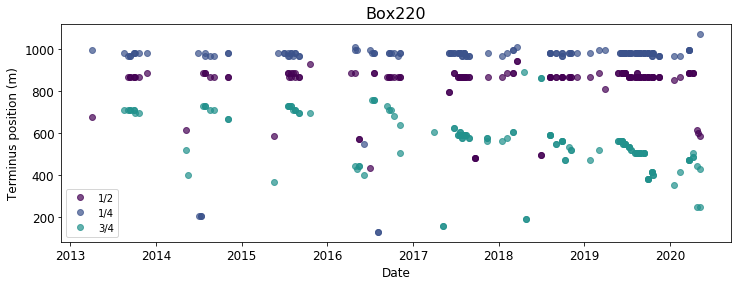

Box232
(1395, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 180 dips
Dropping 135 dips
Dropping 175 dips
Dropping 165 jumps
Dropping 105 jumps
Dropping 219 jumps
114
95
124


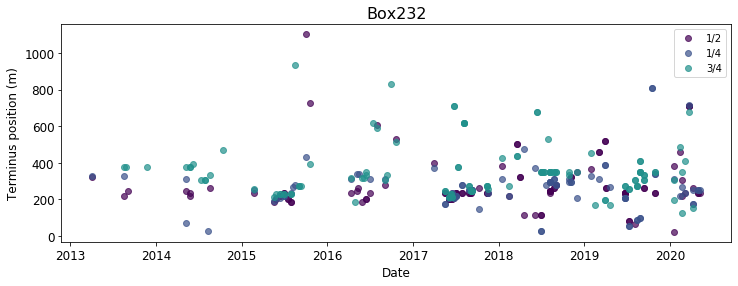

Box238
(1142, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 96 dips
Dropping 23 dips
Dropping 87 dips
Dropping 135 jumps
Dropping 68 jumps
Dropping 122 jumps
171
171
183


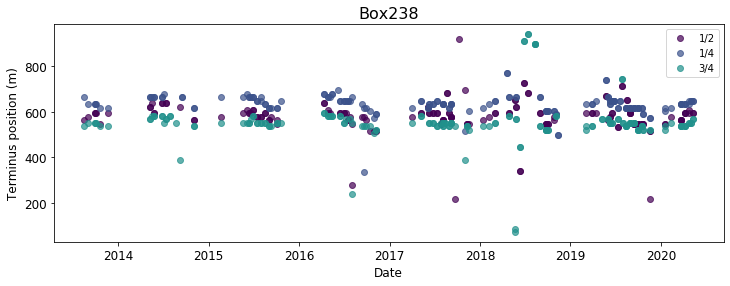

Box244
(737, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 24 dips
Dropping 50 dips
Dropping 72 dips
Dropping 26 jumps
Dropping 24 jumps
Dropping 79 jumps
112
101
102


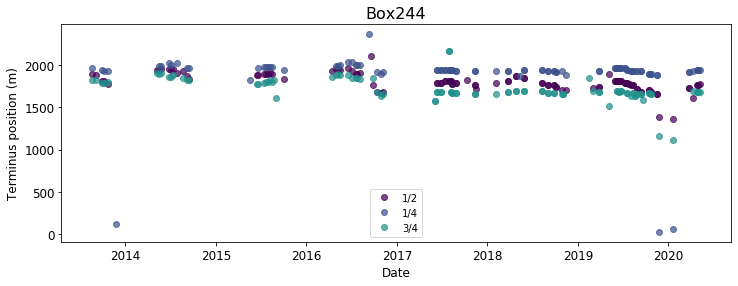

Box250
(623, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 41 dips
Dropping 34 dips
Dropping 40 dips
Dropping 51 jumps
Dropping 38 jumps
Dropping 64 jumps
104
95
101


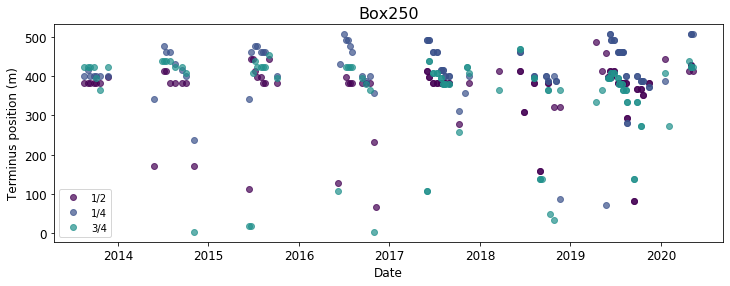

Box268
(690, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 21 dips
Dropping 10 dips
Dropping 56 dips
Dropping 16 jumps
Dropping 25 jumps
Dropping 21 jumps
106
102
106


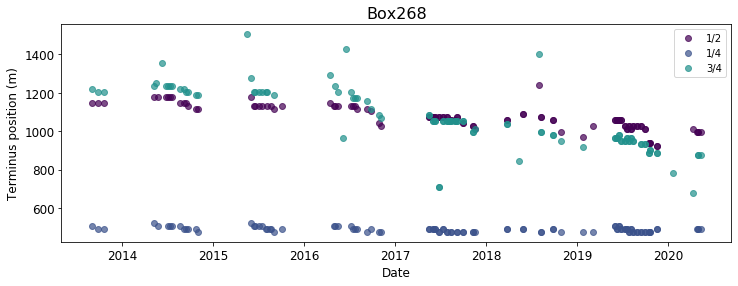

Box274
(1505, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 190 dips
Dropping 132 dips
Dropping 205 dips
Dropping 162 jumps
Dropping 136 jumps
Dropping 159 jumps
170
153
171


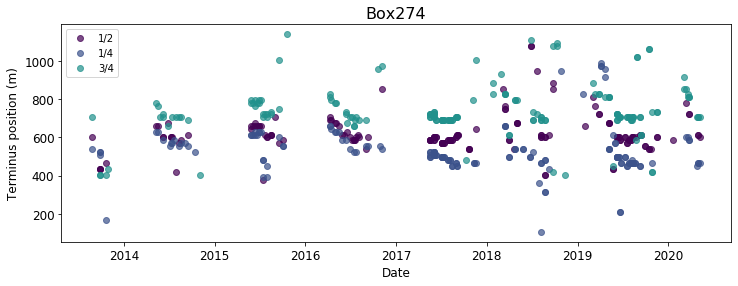

Box286
(1498, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 153 dips
Dropping 56 dips
Dropping 143 dips
Dropping 111 jumps
Dropping 90 jumps
Dropping 123 jumps
135
127
170


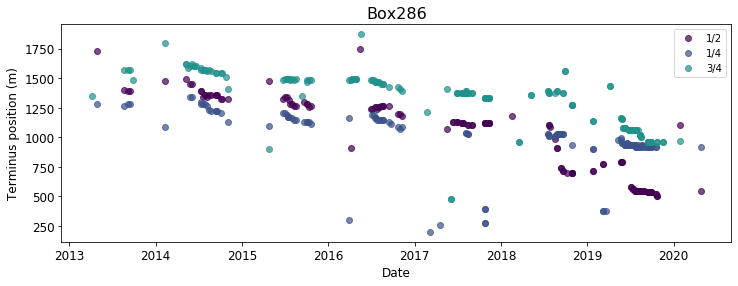

Box292


FileNotFoundError: [Errno 2] File /home/jukes/Documents/Sample_glaciers/terminuspicks_Box292_2020_08_06.csv does not exist: '/home/jukes/Documents/Sample_glaciers/terminuspicks_Box292_2020_08_06.csv'

In [18]:
# inputs to the results_allglaciers function
######################################################################################
DATES_FILENAME = 'imgdates_SE_3.csv'
FLINE_FILENAME = 'Boxes_coords_pathrows_SE_3.csv'
VEL_FILENAME = 'Glacier_vel_manual_SE_3.csv'
date = '2020_08_06' # date that you ran the WTMM (in the terminus pick file name)
######################################################################################
# These are the recommended values used for time series filtering
V = 3 # flow speed scalar multiplier (increase to filter more, decrease to filter less)
N1 = 1 # number of iterations to remove dips (sudden drop below average)
N2 = 1 # number of iterations to remove jumps (sudden jump above average)

results_allglaciers(DATES_FILENAME,FLINE_FILENAME,VEL_FILENAME, date, V, N1, N2)